## Reinforcement Learning, 2024-01 
### Tarea 1

> Daniel Villar, 201923374.  
> Daniel Alvarez, 201911320.

In [2]:
%reset

- Librerias

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

- Punto 1

**Para el problema de multi-armed bandit, implemente un banco de pruebas (testbed) similar al considerado en clase y en el libro de texto, pero con 12 acciones con q(a_k) generadas aleatoriamente de acuerdo a una distribución normal con media 5 y varianza 3, y cada acción con varianza de 1. Resuelva el problema de maximizar la suma de recompensas en un horizonte de tiempo de 4000 iteraciones con los siguientes algoritmos (implementados por usted):**

**ϵ-greedy con recompensa promedio.**

**ϵ-greedy con tamaño de paso constante.**

**Para cada caso ajuste apropiadamente los parámetros requeridos (α y/o ϵ), y grafique
el desempeño de los algoritmos en términos de recompensa recibida y porcentaje de
iteraciones en que se selecciona la acción óptima.**

Inicialmente, importamos las librerías necesarias para la implementación. Luego, definimos una clase para definir las funciones que tiene el Multi-Armed-Bandit. La primera función **__init __** crea diferentes valores centrales para cada acción, a partir de una distribución normal con media 5 y varianza 3, además de inicializar todas las variables necesarias. La segunda función **pullArm** simula tomar una acción en específico (bajar una de las palancas del bandit). En este punto se crea la recompenza de tomar dicha acción, a partir de una distribución normal cuyo centro es el número del bandit y la varianza es 1. La función **epsilon_greedy** describe el algoritmo ϵ-greedy. En esta se crea un número aleatorio en cada ejecución. Cada vez que dicho número es menor que el valor de **ϵ**, se escoge una acción aleatoria entre todas las posiblidades. Eso hace que se aumente la exploración, pues con una probabilidad de ϵ se está tomando una acción que no necesariamente es la óptima, a diferencia del algoritmo greedy. 

Luego, la función **run_experiment** prueba los diferentes valores de ϵ y finalmente la función **plot_results** grafica los resultados obtenidos para cada uno de los ϵ.

Cabe resaltar que, en teoría, si las acciones tuvieran varianza muy grande, se debería escoger un ϵ grande, con el fin de aumentar la exploración. Por el contrario, si las acciones tuvieran varianza muy pequeña, se debería escoger un ϵ pequeño, con el fin de explorar menos y explotar más. 

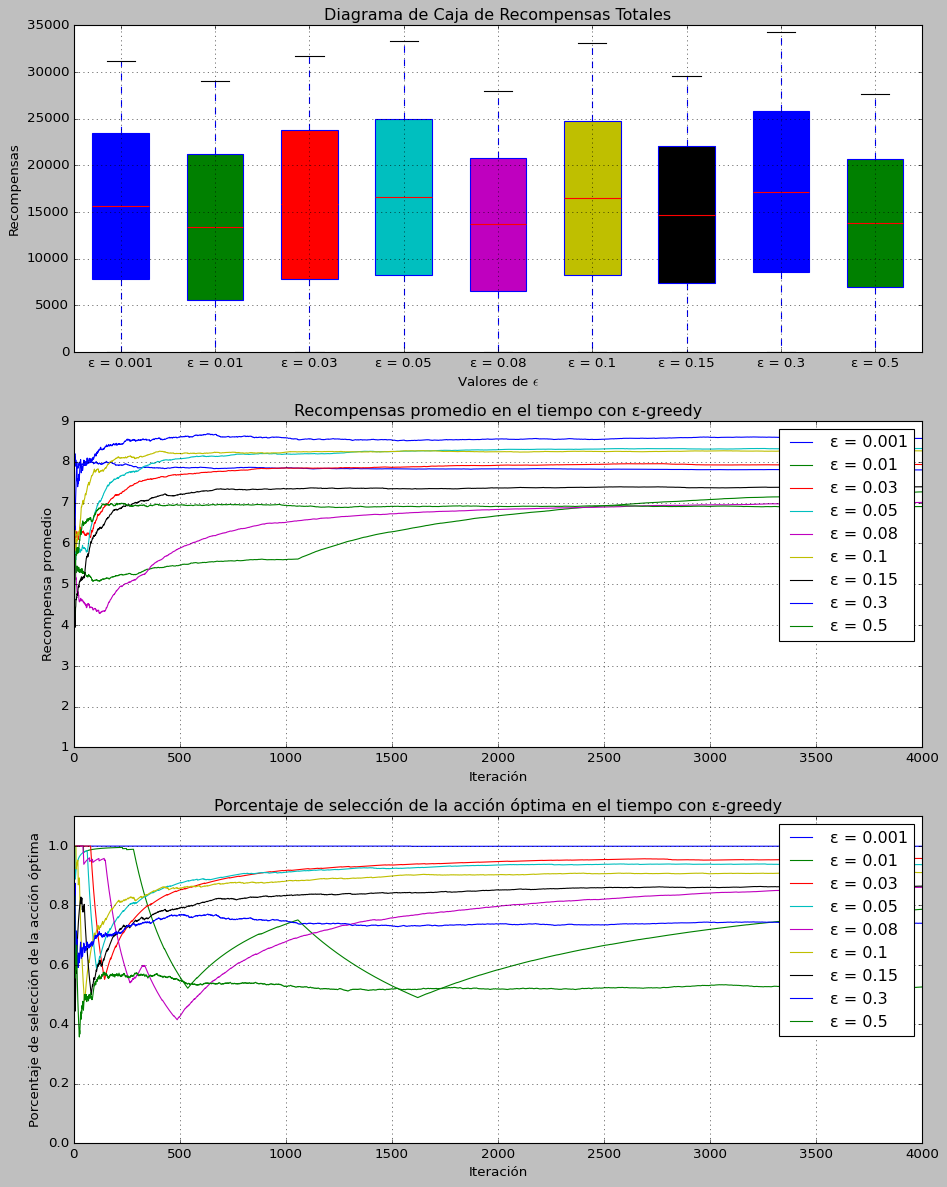

In [6]:
class BanditTestbed:
    # conditions
    np.random.seed(1)

    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.rewards_avg = []
        self.optimal_action_percentage_history = []
        self.bandits = num_bandits

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.q_estimated[action] = self.action_values[action] / (self.action_counts[action] + + 1e-5)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.action_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.action_values / (self.action_counts + 1e-5))
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        rewards_avg = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                '''
                    Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
                    división tienda a infinito cuando el número de acciones tomadas es 0.
                '''
                action = self.greedy() 
            self.pullArm(action, varianceActions)    
            rewards.append(self.total_rewards)
            rewards_avg.append(self.total_rewards / (i + 1))
        return rewards, self.optimal_action_percentage_history, rewards_avg


def run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    rewards_avg = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        rewards_avg.append(rewards_av)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history, rewards_avg


def plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, rewards_avg):
    plt.figure(figsize=(12, 15))
    plt.subplot(3, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.boxplot(rewards_history[i], positions=[i+1], widths=0.6, patch_artist=True, boxprops=dict(facecolor=f'C{i}'))
    plt.xlabel(r'Valores de $\epsilon$')
    plt.ylabel('Recompensas')
    plt.title('Diagrama de Caja de Recompensas Totales')
    plt.xticks(range(1, len(epsilon_values) + 1), [f'ε = {epsilon}' for epsilon in epsilon_values])
    plt.grid()
    plt.tight_layout()
    plt.subplot(3, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_avg[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa promedio')
    plt.title('Recompensas promedio en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.subplot(3, 1, 3)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

Como se puede notar, el ϵ que tiene la mayor recompensa promedio es para ϵ=

**2. Repita el problema anterior, pero ahora con cada acción con varianza de 4.**


En el caso en el que la varianza es 4 para todas las recompesas de las acciones, se analizó lo siguiente:

En el sistema, al tener una mayor varianza en el diagrama de cajas de recompesas, es apreciable la diferenciación entre las recompensas acumuladas, ya que para cada una de las distribuciones de probabilidad de las acciones, dado un valor de $\epsilon$, existe una probabilidad mayor de tener valores más alejados teniendo en cuenta que la distribución para todas las acciones se ha vuelto más grande para un dominio $\real$.

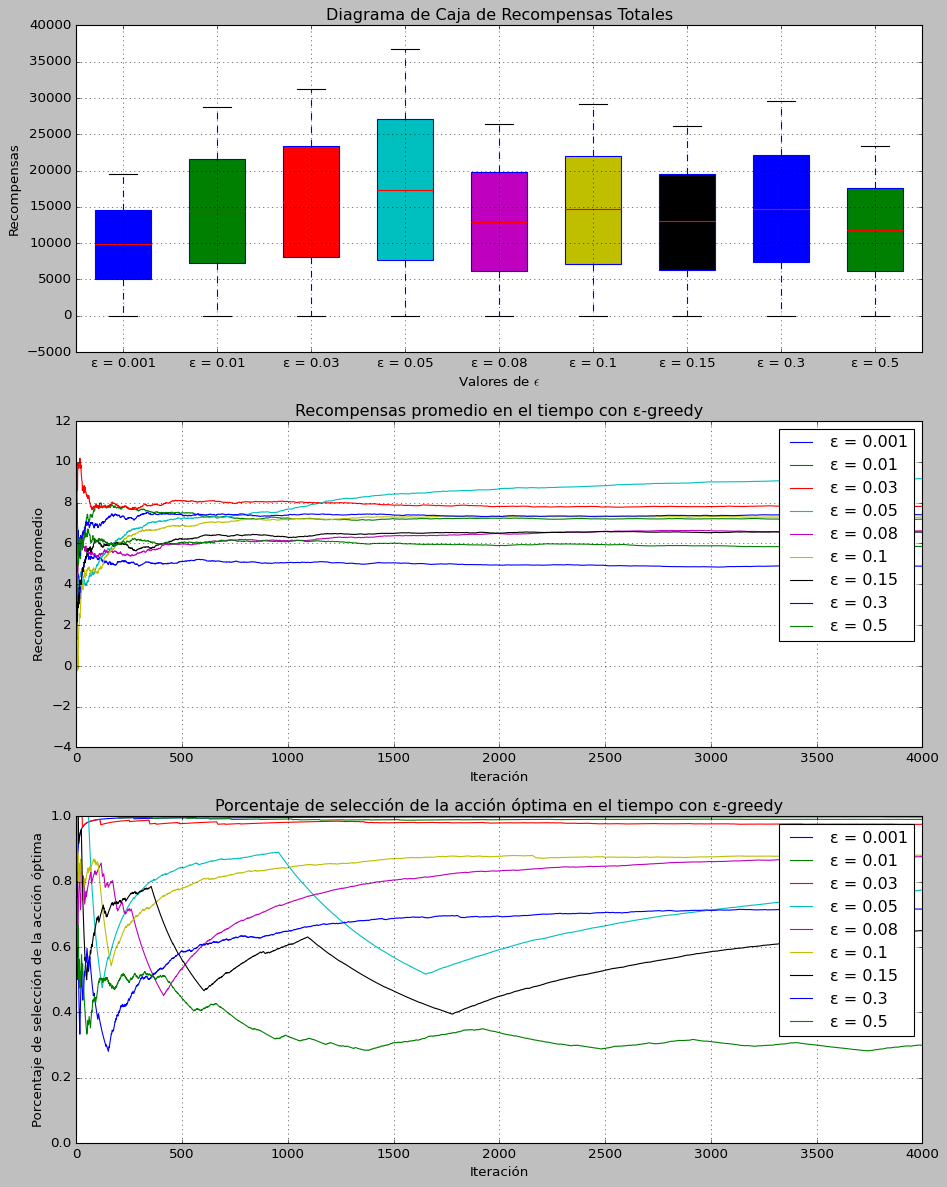

In [4]:
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 4
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

Como se puede notar, ahora 

- Punto 3

En este escenario, la existencia de un mayor número de acciones disponibles en cada estado episódico incrementa significativamente las oportunidades de exploración. Aunque la probabilidad de explorar (determinada por el valor de epsilon, $\epsilon$) se mantiene constante para cada caso, la diversidad ampliada de acciones asegura que, durante la fase de exploración, el algoritmo tenga una mayor probabilidad de seleccionar una acción diferente a la elegida previamente. Esto reduce la probabilidad de repetición de acciones, enriqueciendo así la experiencia. Cuando el algoritmo opta por la estrategia 'greedy', selecciona la mejor acción conocida basándose en las estimaciones actuales de valor. Dado un conjunto suficientemente grande y diverso de acciones, esta metodología garantiza que la política de decisión evolucione de manera más efectiva, beneficiándose de un balance óptimo entre exploración y explotación. La riqueza de opciones disponibles promueve una exploración más exhaustiva del espacio de acciones, lo que potencialmente conduce a una mejor identificación de políticas óptimas en entornos complejos.

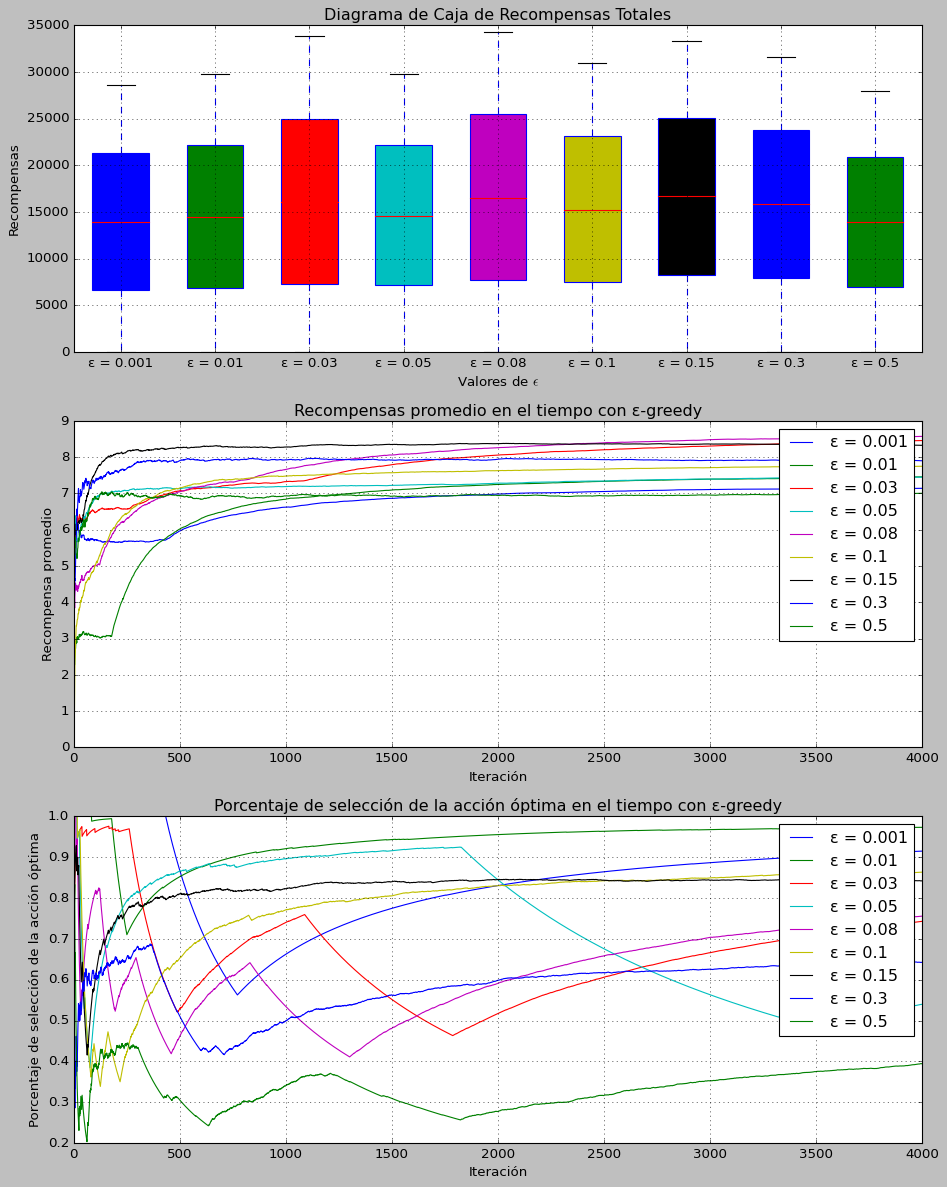

In [5]:
num_bandits = 50
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]
rewards_history, optimal_action_percentage_history, reward_average = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

- Punto 4 

0.9
0.9
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000001
0.9000000000000002
0.9000000000000002
0.9000000000000004
0.9
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9
0.9
0.9
0.9000000000000002
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000001
0.9000000000000001
0.9000000000000002
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9
0.9000000000000002
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000001
0.9
0.9000000000000002
0.9000000000000001
0.9000000000000002
0.9000000000000001
0.9000000000000001
0.90000000

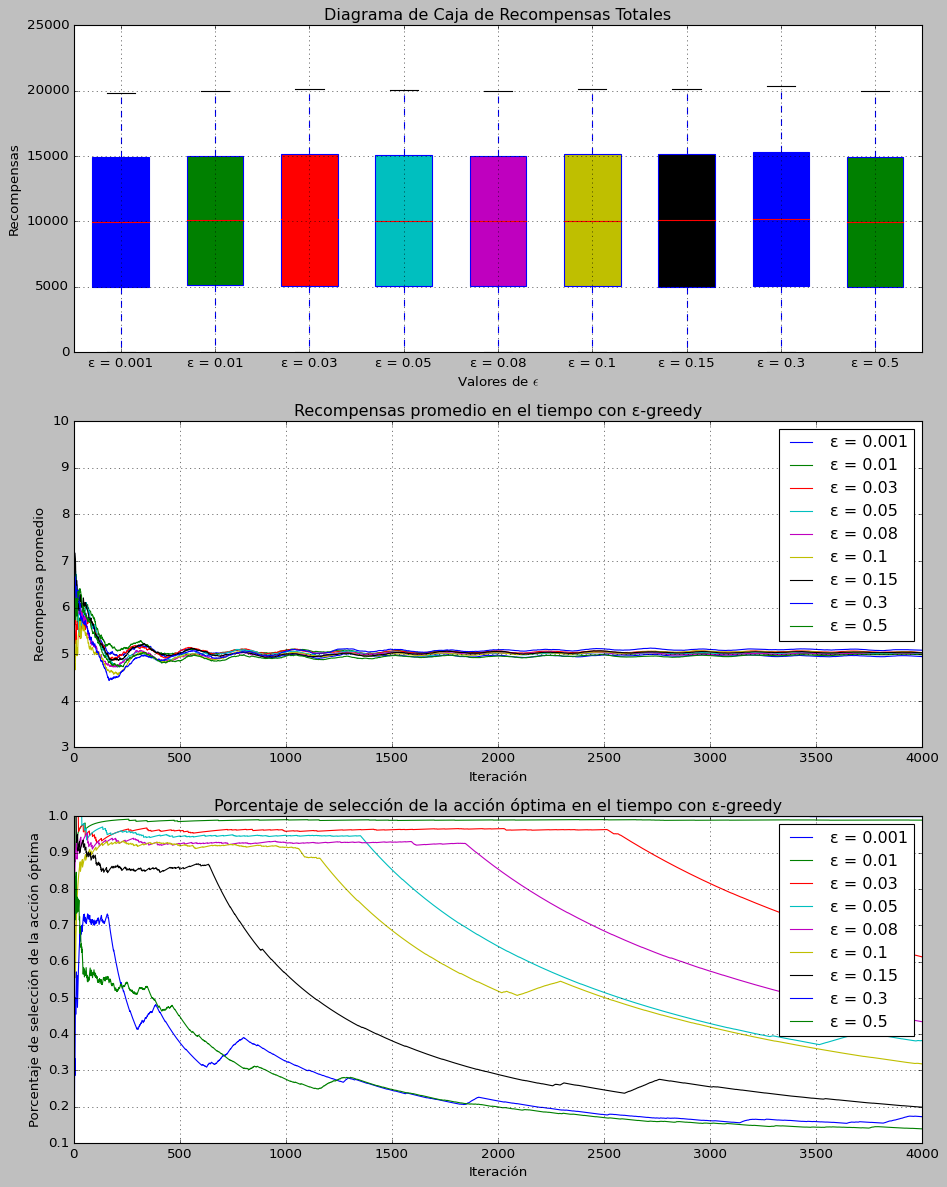

In [10]:
class BanditTestbed_change:
    # conditions
    np.random.seed(0)

    def __init__(self, num_bandits, mean, varianceInitBandits, alpha):
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.Q_sum = np.zeros(num_bandits)
        self.total_rewards = 0
        self.mean = mean
        self.alpha = alpha
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.rewards_avg = []
        self.optimal_action_percentage_history = []
        self.num_bandits = num_bandits
        self.Q_value = np.zeros(num_bandits)
        self.varianceInitBandits = varianceInitBandits

    def pullArm(self, action, varianceActions, iteration):
        
        # desarrollo de media movil con cos

        self.bandits_mean_values = np.random.normal(self.mean + np.cos(( np.pi/120 ) * (iteration - 20)), np.sqrt(self.varianceInitBandits), size=self.num_bandits)
        
        # se toma la recompensa
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)

        self.action_values[action] += reward
        self.action_counts[action] += 1
        index = int(self.action_counts[action])
        
        # se guarda la recompensa

        self.rewards[index, action] = reward
        
        Q_step = 0
        Q_stepp = 0
        # se aplica la segunda suma del termino
        for j in range(1, index):
            Q_stepp += self.alpha * ((1 - self.alpha )**(self.action_counts[action] - j))
            Q_step += self.alpha * ((1 - self.alpha )**(self.action_counts[action] - j))*self.rewards[j, action]
        
        self.Q_sum[action] = ((1 - self.alpha)**(self.action_counts[action]))*self.rewards[0, action] + Q_step

        test = ((1 - self.alpha)**(self.action_counts[action])) + Q_stepp
        
        print(test)
        self.total_rewards += reward
        self.rewards_history.append(reward)
        
        if action == np.argmax(self.action_values):
            self.optimal_action_count += 1
        
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))
        
    def greedy(self):
        action = np.argmax(self.Q_sum)
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        rewards_avg = []
        self.rewards = np.zeros((num_iterations, self.num_bandits))
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                '''
                    Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
                    división tienda a infinito cuando el número de acciones tomadas es 0.
                '''
                action = self.greedy() 
            self.pullArm(action, varianceActions, i)    
            rewards.append(self.total_rewards)
            rewards_avg.append(self.total_rewards / (i + 1))
        return rewards, self.optimal_action_percentage_history, rewards_avg


def run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha):
    rewards_history = []
    rewards_avg = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed_change(num_bandits, mean, varianceInitBandits, alpha)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        rewards_avg.append(rewards_av)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history, rewards_avg

alpha = 0.1
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average  = run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)

1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0000000000000002
1.0
1.0
1.0

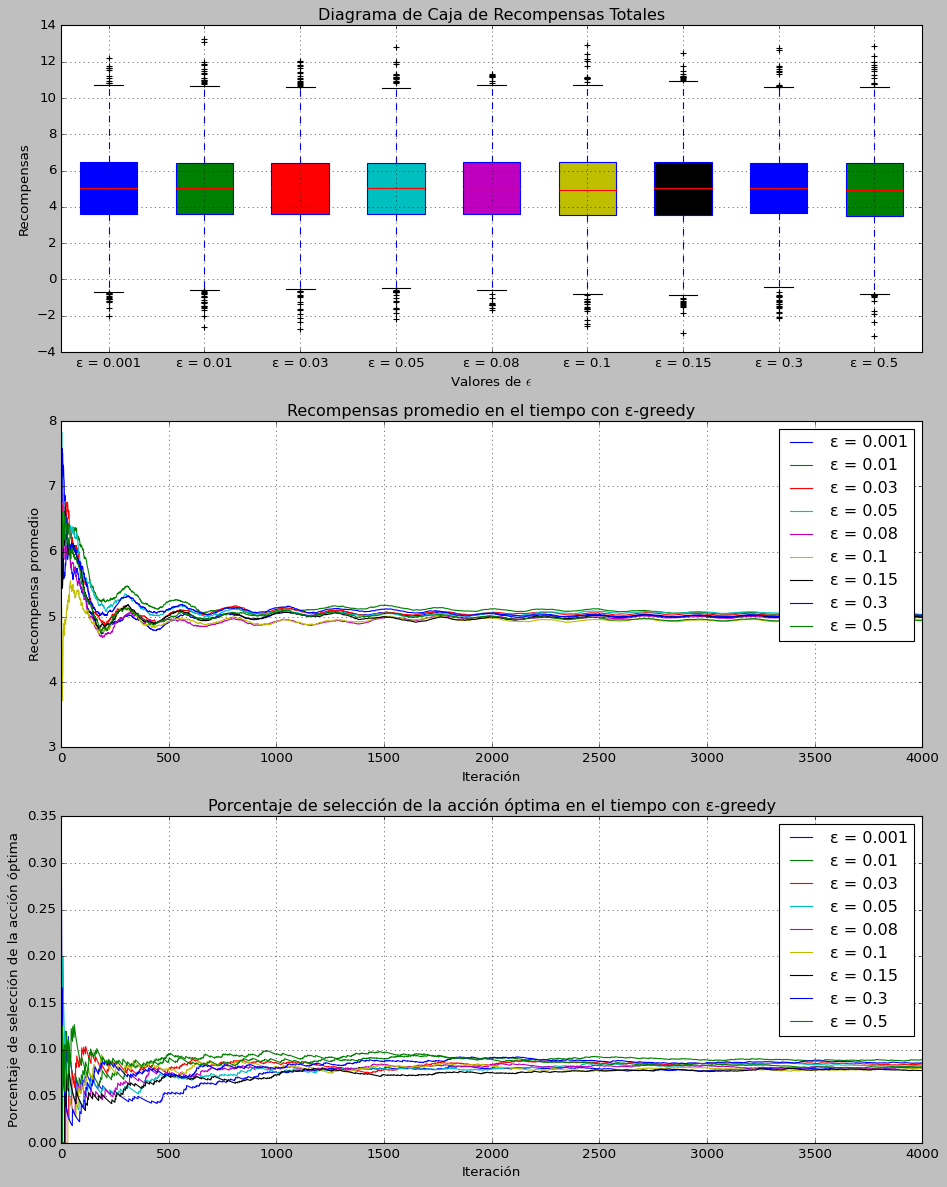

In [9]:
class BanditTestbed_change:
    # conditions
    np.random.seed(1)

    def __init__(self, num_bandits, mean, varianceInitBandits, alpha):
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.Q_sum = np.zeros(num_bandits)
        self.total_rewards = 0
        self.mean = mean
        self.alpha = alpha
        self.q_estimated = np.zeros(num_bandits)
        self.optimal_action_count = 0
        self.rewards_history = []
        self.rewards_avg = []
        self.optimal_action_percentage_history = []
        self.num_bandits = num_bandits
        self.Q_value = np.zeros(num_bandits)
        self.varianceInitBandits = varianceInitBandits

    def pullArm(self, action, varianceActions, iteration):
        # Actualiza la media de los bandidos basándose en la iteración actual
        self.bandits_mean_values = np.random.normal(self.mean + np.cos((np.pi / 120) * (iteration - 20)), np.sqrt(self.varianceInitBandits), size=self.num_bandits)
        
        # Obtiene la recompensa para la acción seleccionada
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)

        # Actualiza la suma de recompensas y el contador para la acción seleccionada
        self.action_values[action] += reward
        self.action_counts[action] += 1
        
        # Asegura la inicialización de la matriz de recompensas
        if not hasattr(self, 'rewards'):
            self.rewards = np.zeros((num_iterations, self.num_bandits))
        
        # Almacena la recompensa en la matriz
        self.rewards[int(self.action_counts[action] - 1), action] = reward
        
        # Inicializa variables para el cálculo de Q_sum
        Q_step = 0
        Q_stepp = 0

        # Calcula la suma ponderada de recompensas pasadas para la acción
        for j in range(int(self.action_counts[action])):
            decay_factor = self.alpha * ((1 - self.alpha) ** (self.action_counts[action] - j - 1))
            Q_stepp += decay_factor
            Q_step += decay_factor * self.rewards[j, action]
        
        # Actualiza Q_sum para la acción seleccionada
        self.Q_sum[action] = ((1 - self.alpha) ** self.action_counts[action]) * self.rewards[0, action] + Q_step
        test = Q_stepp + ((1 - self.alpha) ** self.action_counts[action])
        print(test)
        # Actualiza las métricas de rendimiento
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.bandits_mean_values):  # Comprueba si la acción seleccionada es la óptima
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / np.sum(self.action_counts))  # Actualiza el historial del porcentaje de acciones óptimas

        
    def greedy(self):
        action = np.argmax(self.Q_sum)
        return action

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        # Realiza selecciones de acciones usando la estrategia epsilon-greedy
        for i in range(num_iterations):
            if np.random.rand() < epsilon:
                action = np.random.choice(self.num_bandits)  # Exploración: elige una acción al azar
            else:
                action = self.greedy()  # Explotación: elige la mejor acción según Q_sum
            self.pullArm(action, varianceActions, i)
        
        # Calcula el promedio de recompensas acumuladas en cada paso
        rewards_avg = [np.mean(self.rewards_history[:i + 1]) for i in range(num_iterations)]
        return self.rewards_history, self.optimal_action_percentage_history, rewards_avg



def run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha):
    rewards_history = []
    rewards_avg = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed_change(num_bandits, mean, varianceInitBandits, alpha)
        rewards, optimal_action_percentage, rewards_av = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        rewards_avg.append(rewards_av)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history, rewards_avg

alpha = 0.1
num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history, reward_average  = run_experiment_2(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits, alpha)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history, reward_average)